In [1]:
import os

In [2]:
#os.system("grep HERT all.zpd > HERT.zpd")

In [3]:
import pandas as pd
import datetime
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [4]:
site = ["ANKR"]
import os
for st in site:
    path="/home/engin/Desktop/Python_GIS/GNSS_DATA/{}.zpd".format(st)
    path2="/home/engin/Desktop/Python_GIS/GNSS_DATA/ATM/{}".format(st)
    if not os.path.exists(path2):
        os.makedirs(path2)
    df=pd.read_csv(path, header=None, sep="\s+")

In [5]:
df = df.drop([0,1,2,13,14,15,16], axis=1)
df.columns=["yr","mn","dy","hr","min","sec","zhd","zwd","std","ztd"]
df['DateTime'] = df[['yr', 'mn', 'dy', 'hr','min','sec']].apply(lambda s : datetime.datetime(*s),axis = 1)
df = df.drop(["yr","mn","dy","hr","min","sec"], axis=1)
df=df.dropna()
df.set_index("DateTime", inplace=True)
path_file = path2+"/"+st+".csv"
df.to_csv(path_file)

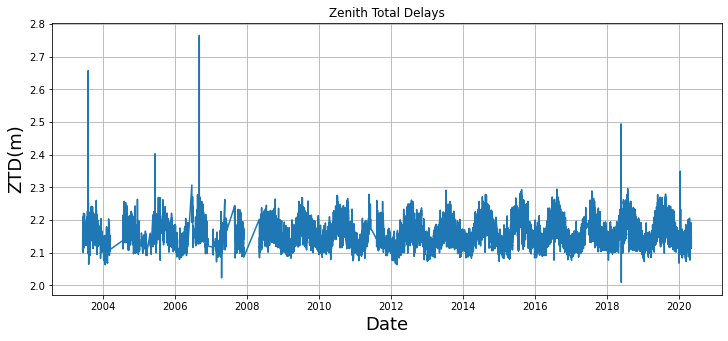

In [6]:
fig1=plt.figure(figsize=(12,5))
plt.title('Zenith Total Delays')
plt.plot(df['ztd'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('ZTD(m)',fontsize=18)
plt.grid(True)
plt.show()
fig1_name = path2+"/"+st+"_1"+".jpeg"
fig1.savefig(fig1_name, dpi=600)

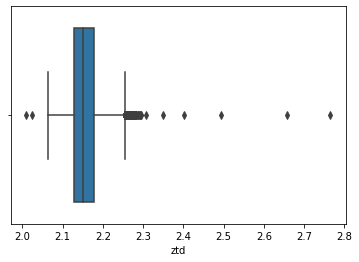

In [7]:
ax = sns.boxplot(x=df['ztd'])
fig2_name = path2+"/"+st+"_snsplot"+".jpeg"
plt.savefig(fig2_name)

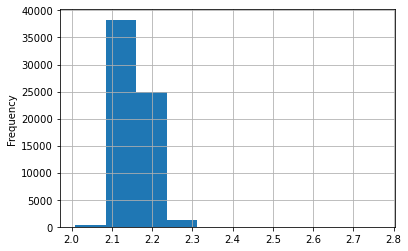

In [8]:
ax = df["ztd"].plot.hist()
fig3_name = path2+"/"+st+"_histplot"+".jpeg"
plt.grid()
plt.savefig(fig3_name)

In [9]:
Q1=df["ztd"].quantile(0.20)
Q3=df["ztd"].quantile(0.80)
IQR=Q3-Q1
filter = (df['ztd'] >= Q1 - 1.5 * IQR) & (df['ztd'] <= Q3 + 1.5 *IQR)
df=df.loc[filter]

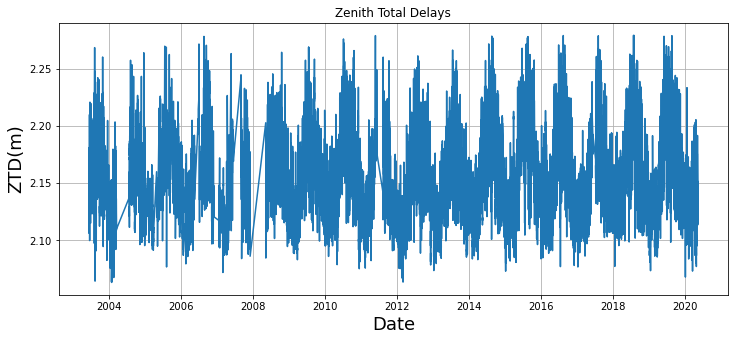

In [10]:
fig3=plt.figure(figsize=(12,5))
plt.title('Zenith Total Delays')
plt.plot(df['ztd'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('ZTD(m)',fontsize=18)
plt.grid(True)
plt.show()
fig3_name = path2+"/"+st+"_outlier_removed"+".jpeg"
fig3.savefig(fig3_name, dpi=600)

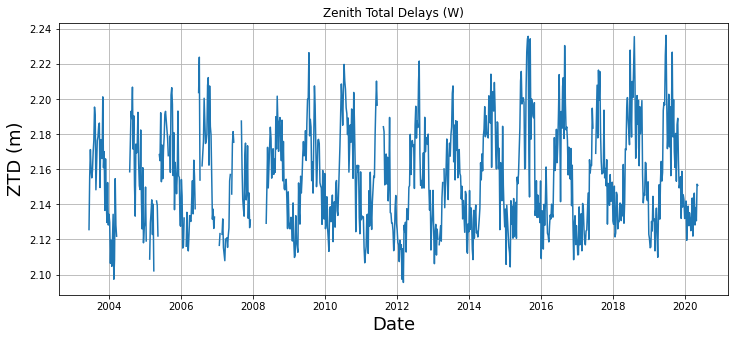

In [11]:
df=df.resample("W").mean()
fig4=plt.figure(figsize=(12,5))
plt.title('Zenith Total Delays (W)')
plt.plot(df['ztd'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('ZTD (m)',fontsize=18)
plt.grid(True)
plt.show()
fig4_name = path2+"/"+st+"_weekly"+".jpeg"
fig4.savefig(fig4_name, dpi=600)

In [12]:
df.reset_index(inplace=True)
df=df.filter(["DateTime","ztd"])
df=df.dropna()
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])

/home/engin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


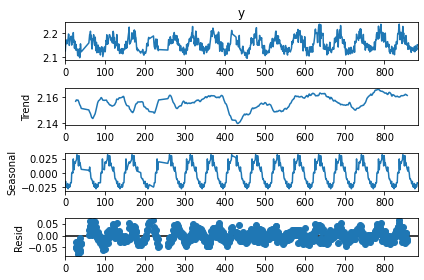

In [13]:
result = seasonal_decompose(df["y"], model="add", freq=52)
result.plot();
fig5_name = path2+"/"+st+"_seasonal_decompose"+".jpeg"
plt.savefig(fig5_name, dpi=600);

In [14]:
df

,ds,y
0,2003-06-08,2.125635
1,2003-06-15,2.155899
2,2003-06-22,2.171304
3,2003-06-29,2.159652
4,2003-07-06,2.155158
...,...,...
879,2020-04-12,2.128245
880,2020-04-19,2.138203
881,2020-04-26,2.130656
882,2020-05-03,2.151543


In [ ]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [3]:
future = m.make_future_dataframe(periods=52,freq = 'W')
forecast = m.predict(future)
fcst = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
path_file2 = path2+"/"+st+"_prophet_fcst.csv"
fcst.to_csv(path_file2)

NameError: name 'df' is not defined

In [ ]:
m.plot(forecast);
fig6_name = path2+"/"+st+"_forecast_prophet"+".jpeg"
plt.savefig(fig6_name)

In [ ]:
m.plot_components(forecast, figsize=(18,10));
fig7_name = path2+"/"+st+"_forecast_decompose"+".jpeg"
plt.savefig(fig7_name)

In [ ]:
pred=forecast["yhat"].iloc[:len(df)].values
true = df["y"].values

In [ ]:
# calculate MAE between expected and predicted values for december
from sklearn.metrics import mean_absolute_error
from math import sqrt

mae = mean_absolute_error(true, pred)
rmse = sqrt(mae)

# initialize list of lists 
data = [['mae', mae], ['rmse', rmse]]
df_score = pd.DataFrame(data, columns = ['MAE', 'RMSE']) 

path_file_metric = path2+"/"+st+"accuracy.csv"
df_score.to_csv(path_file_metric)
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

TRAIN-TEST SPLIT

In [ ]:
train = df.iloc[:800]
test = df.iloc[800:]

In [ ]:
m = Prophet(weekly_seasonality = True)
m.fit(train)
future = m.make_future_dataframe(periods=85,freq='W')
forecast = m.predict(future)

In [ ]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(18,10))

test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax)

In [ ]:
from statsmodels.tools.eval_measures import rmse
predictions = forecast.iloc[800:885]['yhat']
rmse(predictions,test['y'])

In [ ]:
import matplotlib.pyplot as plt
fig = m.plot(forecast,xlabel="ds",ylabel="y");

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [ ]:
# Initial 5 years training period
initial = 5 * 365
initial = str(initial) + ' days'
# Fold every 5 years
period = 1 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

In [ ]:
df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon)

In [ ]:
df_cv.head()

In [ ]:
performance_metrics(df_cv)

In [ ]:
plot_cross_validation_metric(df_cv, metric='rmse');

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)